In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bisect

In [2]:
beale_mod = lambda x,y : (1.5 - x + x*y)**2 + (2.25 - x + x*(y**2))**2 + (2.625 - x + x*(y**3))**2 + abs(x) + y**2
beale_g_der = lambda x,y : np.array([x - x*y - 1.5,x-x*y**2-2.25, x-x*y**3-2.625])
A = lambda y: np.array([[1-y],[1-y**2],[1-y**3]])
x = lambda x: np.array([x])

In [3]:
def numgrad(f,x,h = 1e-9):
    dim = len(x)
    coords = []
    for i in range(dim):
        coords.append(np.linspace(x[i]-h, x[i]+h,3))
    x_grid = np.meshgrid(*coords)
    V = f(*x_grid)
    ind = tuple([1]*dim)
    res = np.array([x[ind] / h for x in np.gradient(V)])
    res[0], res[1] = res[1], res[0]
    return(res)

In [4]:
def SGD(f, st, lr1,lr2, num_it, use_cogd=False, g_der=None, alpx=None,alpA=None,beta=None,k = None):
    cur = st
    path = []
    path.append(cur)
    for _ in range(num_it):
        grad = numgrad(f,cur)
        cur = cur - np.multiply([lr2,lr1],grad)
        if(use_cogd):
            CoGD(g_der,cur,path[-1],alpx,alpA,beta,k)
        path.append(cur)
    return cur,path

In [5]:
def conv_cond(x, A, alpx, alpA):
    R_A = np.linalg.norm([A], ord=2)**2
    R_x = np.linalg.norm([x], ord=1)
    return (R_x < alpx) and (R_A >= alpA)
def CoGD(g_der, cur, prev, alpx, alpA, lr3, k):
    if conv_cond(cur[0],cur[1],alpx, alpA):
        c = g_der(*cur)@(A(cur[1])-A(prev[1]))/(x(cur[0])-x(prev[0]))
        #c = g_der(*cur)*(cur[1]-prev[1])/(cur[0]-prev[0])
        c = np.sign(c)*abs(c)**k
        cur[0] = cur[0] + 0.001*lr3*c*prev[0]
    return cur

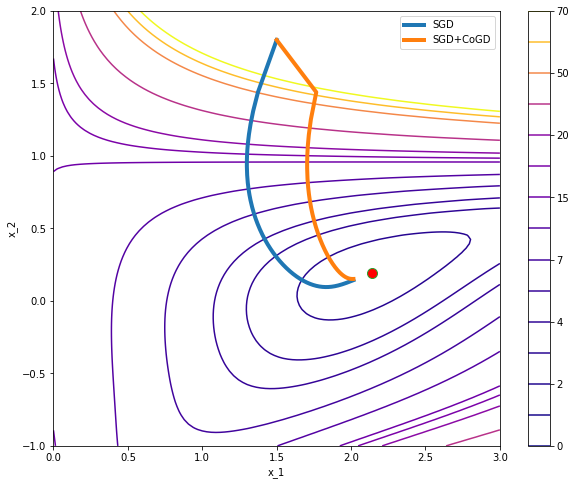

In [6]:
    a,path = SGD(beale_mod,[1.5,1.8],0.001,0.001,500)
    b,path_alt = SGD(beale_mod,[1.5,1.8],0.001,0.001,250,True,beale_g_der,1.4,0.5,0.01,2)
    x1, x2 = zip(*path)
    alt_x1, alt_x2 = zip(*path_alt)
    plt.figure(figsize=(10,8))
    plt.plot(x1,x2,linewidth = 4,label='SGD')
    plt.plot(alt_x1,alt_x2,linewidth = 4,label='SGD+CoGD')
    plt.plot(2.13829, 0.194514, marker="o", markersize=10, markerfacecolor="red")
    X, Y = np.meshgrid(np.linspace(0, 3, 100), np.linspace(-1, 2, 100))
    Z = beale_mod(X, Y)
    plt.contour(X, Y, Z,levels=[0,1,2,3,4,5,7,10,15,17,20,30,50,60,70],cmap='plasma');
    plt.colorbar();
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    plt.legend()
    plt.show()

In [7]:
def Momentum(f, st, lr1,lr2, mnt, num_it, use_cogd=False, g_der=None, alpx=None,alpA=None,beta=None, k =None):
    cur = st
    delta = np.array([0,0])
    path = []
    path.append(cur)
    for _ in range(num_it):
        grad = numgrad(f,cur)
        delta = mnt*delta - np.multiply([lr2,lr1],grad)
        cur = cur + delta
        if(use_cogd):
            CoGD(g_der,cur,path[-1],alpx,alpA,beta,k)
        path.append(cur)
    return cur,path

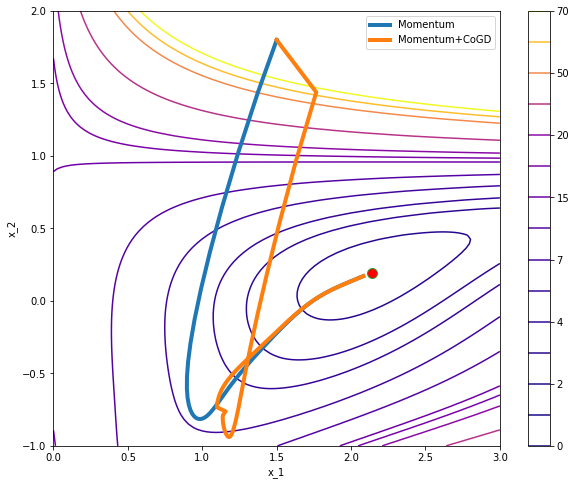

In [8]:
a,path = Momentum(beale_mod,[1.5,1.8],0.001,0.001,0.8,200)
b,path_alt = Momentum(beale_mod,[1.5,1.8],0.001,0.001,0.8,200,True,beale_g_der,1.5,0.5,0.01,2)
x1, x2 = zip(*path)
alt_x1, alt_x2 = zip(*path_alt)
plt.figure(figsize=(10,8))
plt.plot(x1,x2,linewidth = 4,label='Momentum')
plt.plot(alt_x1,alt_x2,linewidth = 4,label='Momentum+CoGD')
plt.plot(2.13829, 0.194514, marker="o", markersize=10, markerfacecolor="red")
X, Y = np.meshgrid(np.linspace(0, 3, 100), np.linspace(-1, 2, 100))
Z = beale_mod(X, Y)
plt.contour(X, Y, Z,levels=[0,1,2,3,4,5,7,10,15,17,20,30,50,60,70],cmap='plasma');
plt.colorbar();
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.legend()
plt.show()

In [9]:
def Adam(f, st, lr1,lr2,beta1,beta2, num_it, use_cogd=False, g_der=None, alpx=None,alpA=None,beta=None, k =None):
    eps = 1e-15
    cur = st
    mt = np.array([0,0])
    vt = np.array([0,0])
    cb1 = beta1
    cb2 = beta2
    path = []
    path.append(cur)
    for _ in range(num_it):
        grad = numgrad(f,cur)
        mt = beta1*mt + (1-beta1)*grad
        vt = beta2*vt + (1-beta2)*np.square(grad)
        used_mt = mt/(1-cb1)
        used_vt = vt/(1-cb2)
        cb1*=beta1
        cb2*=beta2
        cur = cur - np.multiply([lr2,lr1],np.divide(used_mt,np.add(np.sqrt(used_vt),[eps,eps])))
        if(use_cogd):
            CoGD(g_der,cur,path[-1],alpx,alpA,beta,k)
        path.append(cur)
    return cur,path

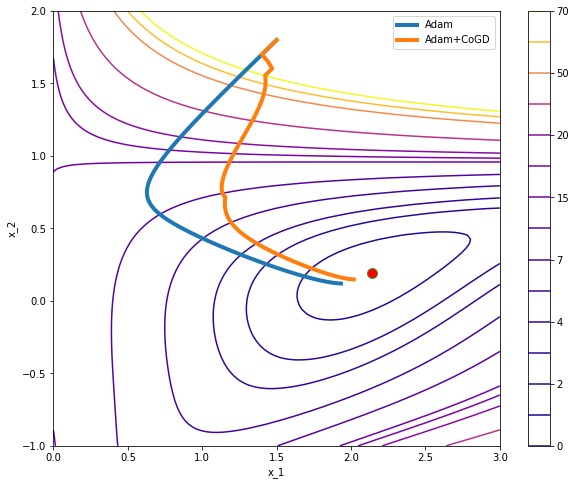

In [10]:
a,path = Adam(beale_mod,[1.5,1.8],0.05,0.05,0.9,0.999,200)
b,path_alt = Adam(beale_mod,[1.5,1.8],0.05,0.05,0.9,0.999,200,True,beale_g_der,1.4,0.5,0.01,2)
x1, x2 = zip(*path)
alt_x1, alt_x2 = zip(*path_alt)
plt.figure(figsize=(10,8))
plt.plot(x1,x2,linewidth = 4,label='Adam')
plt.plot(alt_x1,alt_x2,linewidth = 4,label='Adam+CoGD')
plt.plot(2.13829, 0.194514, marker="o", markersize=10, markerfacecolor="red")
X, Y = np.meshgrid(np.linspace(0, 3, 100), np.linspace(-1, 2, 100))
Z = beale_mod(X, Y)
plt.contour(X, Y, Z,levels=[0,1,2,3,4,5,7,10,15,17,20,30,50,60,70],cmap='plasma');
plt.colorbar();
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.legend()
plt.show()

In [219]:
def ConvCond_bm(A,x, alpA, alpx):
    R_A = np.linalg.norm(A, ord=2)**2
    R_x = np.linalg.norm(x, ord=1)
    return (R_x < alpx) and (R_A >= alpA)

def R(m,p):
    return np.linalg.norm(m,ord=p)**p
    
def CoGD_bm(A_prev, A_cur, x_prev,x_cur,lr2,alpA, alpx, lr3, k, dradrx, newcond, poschange, keepsign,maxthresh = 2000,minthresh = 1e-4):
    res = np.copy(x_cur)
    dRx = R(x_cur,1)-R(x_prev,1)
    dRA = R(A_cur,2)**2-R(A_prev,2)**2
    if (not newcond and ConvCond_bm(A_cur,x_cur,alpA,alpx)) or (newcond and dRx > 1e-6 and abs(dRA/dRx) > dradrx):
        dadx = np.divide(A_cur-A_prev,np.squeeze(x_cur-x_prev))
        for i in range (dadx.shape[1]):
            if (abs(x_prev[i,0]) < minthresh or abs(dRx) < minthresh):
                dadx[:,i] = 1
        
        c = (2*((A_prev@x_prev-b).T)@dadx).T
        if(keepsign):
            c = np.sign(c)*np.power(np.absolute(c),k)
        else:
            c = np.power(np.absolute(c),k)
    

        for i in range (c.shape[0]):
            if abs(c[i,0]) > maxthresh:
                c[i,0] = np.sign(c[i,0])*maxthresh
        if(poschange == 0):
            res = x_cur + lr3*lr2*np.multiply(c,x_prev)
        elif (poschange == 1):
            res = x_prev + lr3*lr2*np.multiply(c,x_prev)
        elif (poschange == 2):
            res = x_cur - lr3*lr2*np.multiply(c,x_prev)
    return res

def med_sorted(m):
    m_size = len(m)
    if m_size%2 == 1:
        return m[m_size//2]
    else:
        return (m[m_size//2 - 1]+m[m_size//2])/2

def Adam_bm(b, x_len, lamb, lr1,lr2,A0,x0, beta1, beta2, num_it, use_cogd=False,
            newcond=False,poschange=0,keepsign = False,alpA=None,dradrx=None,lr3=None, k =None):
    eps = 1e-15
    A = np.copy(A0)
    x = np.copy(x0) 
    mt = np.array([np.zeros(A.shape),np.zeros(x.shape)],dtype=object)
    vt = np.copy(mt)
    cb1 = beta1
    cb2 = beta2
    G = []
    AR = []
    xR = []
    TEST = []
    for t in range(num_it):
        grad = np.array([2*(A@x-b)@(x.T)+2*A,2*(A.T)@(A@x-b)+lamb*np.sign(x)],dtype=object)
        mt = beta1*mt + (1-beta1)*grad
        vt = beta2*vt + (1-beta2)*np.square(grad)
        used_mt = mt/(1-cb1)
        used_vt = vt/(1-cb2)
        cb1*=beta1
        cb2*=beta2
        A_prev = np.copy(A)
        x_prev = np.copy(x)
        A = A - lr1*np.divide(used_mt[0],np.add(np.sqrt(used_vt[0]),np.full(used_vt[0].shape,eps)))
        x = x - lr2*np.divide(used_mt[1],np.add(np.sqrt(used_vt[1]),np.full(used_vt[1].shape,eps)))
        bisect.insort(AR,R(A,2))
        bisect.insort(xR,R(x,1))
        TEST.append(R(x,1))
        if(use_cogd):
            x = CoGD_bm(A_prev, A, x_prev, x, lr2, alpA, med_sorted(xR),lr3,k,dradrx,newcond,poschange,keepsign)
        G.append(np.linalg.norm(b-A@x,ord=2)**2 + lamb*np.linalg.norm(x,ord=1)+np.linalg.norm(A,ord=2))
    plt.plot(TEST)
    return A,x,G

In [220]:
#b = np.array([[2,5,-3]]).T
#b = np.array([[0,10,7,3,2,5,-3,-5]]).T
#b = np.array([[5, 7, 0, 9, -6, -2, 0, 5, -3, 9, 7, -3, 3, 10, 8, -9, 7, -6, 0, -8]]).T
b = np.random.randint(-1,10,size=(50,1))
np.linalg.norm(b,ord=2)**2

1625.9999999999995

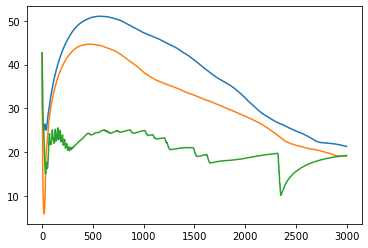

<Figure size 720x576 with 0 Axes>

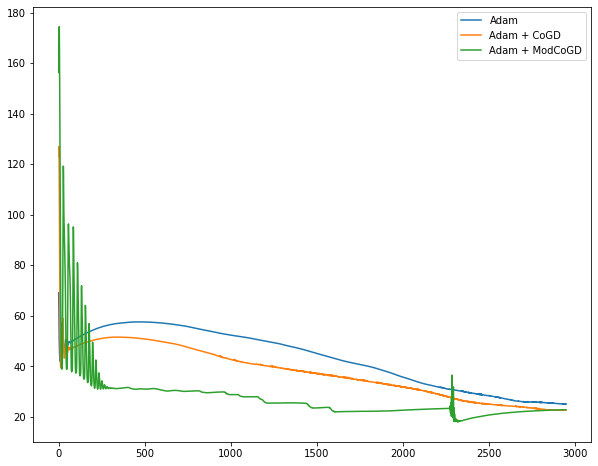

Adam min_G: 24.883665030413656
Adam + CoGD min_G: 22.560453944638958
Adam + ModCoGD min_G: 22.785041068746335
Baseline-Adam 2997
CoGD 2556
ModCoGD 1497


In [221]:
#x_len = 2
x_len = 100
alpA = 30
n_it = 3000
st = 50
A0 = np.random.rand(len(b),x_len)
x0 = np.random.rand(x_len,1)
Ar,xr,Gr = Adam_bm(b,x_len,1,0.05,0.05,A0,x0,0.9,0.999,n_it)
Ar_cgd,xr_cgd,Gr_cgd = Adam_bm(b,x_len,1,0.05,0.05,A0,x0,0.9,0.999,n_it,True,False,2,False,alpA,50,0.001,2)
Ar_modcgd,xr_modcgd,Gr_modcgd = Adam_bm(b,x_len,1,0.05,0.05,A0,x0,0.9,0.999,n_it,True,True,2,False,alpA,100,0.0005,2)
plt.figure(figsize=(10,8))
plt.show()
#Ar_truemodcgd,xr_truemodcgd,Gr_truemodcgd = Adam_bm(b,x_len,1,0.05,0.05,A0,x0,0.9,0.999,n_it,True,False,2,False,alpA,50,0.005,2)
plt.figure(figsize=(10,8))
plt.plot(Gr[st:-1],label ='Adam')
plt.plot(Gr_cgd[st:-1],label = 'Adam + CoGD')
plt.plot(Gr_modcgd[st:-1],label = 'Adam + ModCoGD')
#plt.plot(Gr_truemodcgd[st:-1],label = 'Adam + TrueModCoGD')
plt.legend()
plt.show()
print('Adam min_G:', Gr[-1])
print('Adam + CoGD min_G:', Gr_cgd[-1])
print('Adam + ModCoGD min_G:', Gr_modcgd[-1])
#print('Adam + TrueModCoGD min_G:', Gr_truemodcgd[-1])
eps = 1e-1
baseline = np.argmin(Gr)
print('Baseline-Adam',baseline)
print('CoGD',np.argwhere(Gr_cgd<Gr[baseline]+eps)[0,0])
print('ModCoGD',np.argwhere(Gr_modcgd<Gr[baseline]+eps)[0,0])
#print('TrueModCoGD',np.argwhere(Gr_truemodcgd<Gr[baseline]+eps)[0,0])